In [1]:
import keras as kr
import qkeras as qkr
import numpy as np
import tensorflow as tf
import pandas as pd


Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("CALQ_output_10x.csv")  ## big  300k file

In [4]:
normData = data.apply(lambda x: x/max(x),axis=1)
inputdata = normData.values

In [5]:
Nsamples = 50000
inputdata = normData.values[1:Nsamples]

In [6]:
shaped_data = np.reshape(inputdata,(len(inputdata),12,4,1))

In [7]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(12,4,1),name='input')  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same',name='conv2d_0_m')(input_img)
x = MaxPooling2D((2, 2), padding='same',name='mp_0')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same',name='conv2d_1_m')(x)
x = MaxPooling2D((2, 2), padding='same',name='mp_1')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same',name='conv2d_2_m')(x)
encoded = MaxPooling2D((2, 2), padding='same',name='mp_2')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(4, (3, 3), activation='relu', padding='same',name='conv2d_3_m')(encoded)
x = UpSampling2D((2, 2),name='up_0')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same',name='conv2d_4_m')(x)
x = UpSampling2D((2, 2),name='up_1')(x)
x = Conv2D(16, (3, 3), activation='relu',name='conv2d_5_m')(x)
x = UpSampling2D((2, 2),name='up_2')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='conv2d_6_m')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
kqbit,bqbit = 4
kb = {
        "kernel": "quantized_bits(" + str(kqbit) + ")",
        "bias": "quantized_bits(" + str(bqbit) + ")"
    }

from qkeras import *
q_dict = {
    "conv2d_0_m": kb,
    "conv2d_1_m": kb,
    "conv2d_2_m": kb,
    "conv2d_3_m": kb,
    "conv2d_4_m": kb,
    "conv2d_5_m": kb,    
    "conv2d_6_m": kb,    
    "mp_0": kb,        
    "mp_1": kb,        
    "mp_2": kb,   
    "up_0": kb, 
    "up_1": kb, 
    "up_2": kb  
}

qautoencoder, _ = qkr.model_quantize(autoencoder, q_dict, 4)
qautoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
qautoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 12, 4, 1)          0         
_________________________________________________________________
conv2d_0_m (QConv2D)         (None, 12, 4, 16)         160       
_________________________________________________________________
mp_0 (MaxPooling2D)          (None, 6, 2, 16)          0         
_________________________________________________________________
conv2d_1_m (QConv2D)         (None, 6, 2, 8)           1160      
_________________________________________________________________
mp_1 (MaxPooling2D)          (None, 3, 1, 8)           0         
_________________________________________________________________
conv2d_2_m (QConv2D)         (None, 3, 1, 4)           292       
_________________________________________________________________
mp_2 (MaxPooling2D)          (None, 2, 1, 4)           0         
__________

In [9]:
encoder = kr.Model(input_img, encoded)
qencoder, _ = qkr.model_quantize(encoder, q_dict, 4)
qkr.model_quantize(encoder)
qencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 12, 4, 1)          0         
_________________________________________________________________
conv2d_0_m (QConv2D)         (None, 12, 4, 16)         160       
_________________________________________________________________
mp_0 (MaxPooling2D)          (None, 6, 2, 16)          0         
_________________________________________________________________
conv2d_1_m (QConv2D)         (None, 6, 2, 8)           1160      
_________________________________________________________________
mp_1 (MaxPooling2D)          (None, 3, 1, 8)           0         
_________________________________________________________________
conv2d_2_m (QConv2D)         (None, 3, 1, 4)           292       
_________________________________________________________________
mp_2 (MaxPooling2D)          (None, 2, 1, 4)           0         
Total para

In [10]:
validation_frac = 0.2
N = round(len(shaped_data)*validation_frac)

#randomly select 25% entries
index = np.random.choice(shaped_data.shape[0], N, replace=False)  
#select the indices of the other 75%
full_index = np.array(range(0,len(shaped_data)))
train_index = np.logical_not(np.in1d(full_index,index))

val_input = shaped_data[index]
train_input = shaped_data[train_index]

In [11]:
es = kr.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = qautoencoder.fit(train_input,train_input,
                epochs=150,
                batch_size=256,
                shuffle=True,
                validation_data=(val_input,val_input),
                callbacks=[es])




Train on 39999 samples, validate on 10000 samples
Epoch 1/150





39999/39999 [==============================] - 7s 165us/step - loss: 0.3322 - val_loss: 0.2678
Epoch 2/150
39999/39999 [==============================] - 4s 108us/step - loss: 0.2654 - val_loss: 0.2634
Epoch 3/150
39999/39999 [==============================] - 4s 106us/step - loss: 0.2632 - val_loss: 0.2633
Epoch 4/150
39999/39999 [==============================] - 4s 105us/step - loss: 0.2619 - val_loss: 0.2624
Epoch 5/150
39999/39999 [==============================] - 4s 104us/step - loss: 0.2606 - val_loss: 0.2596
Epoch 6/150
39999/39999 [==============================] - 4s 105us/step - loss: 0.2593 - val_loss: 0.2584
Epoch 7/150
39999/39999 [==============================] - 4s 112us/step - loss: 0.2577 - val_loss: 0.2572
Epoch 8/150
39999/39999 [==============================] - 4s 112us/step - loss: 0.2559 - val_loss: 0.2552
Epoch 9/150
39999/39999 [==============================] - 4s 111us/step - loss: 0.254

39999/39999 [==============================] - 4s 106us/step - loss: 0.2249 - val_loss: 0.2251
Epoch 60/150
39999/39999 [==============================] - 4s 108us/step - loss: 0.2247 - val_loss: 0.2240
Epoch 61/150
39999/39999 [==============================] - 4s 105us/step - loss: 0.2242 - val_loss: 0.2248
Epoch 62/150
39999/39999 [==============================] - 4s 108us/step - loss: 0.2241 - val_loss: 0.2265
Epoch 63/150
39999/39999 [==============================] - 4s 106us/step - loss: 0.2237 - val_loss: 0.2234
Epoch 64/150
39999/39999 [==============================] - 4s 104us/step - loss: 0.2232 - val_loss: 0.2241
Epoch 65/150
39999/39999 [==============================] - 4s 107us/step - loss: 0.2231 - val_loss: 0.2245
Epoch 66/150
39999/39999 [==============================] - 4s 109us/step - loss: 0.2231 - val_loss: 0.2243
Epoch 67/150
39999/39999 [==============================] - 4s 107us/step - loss: 0.2229 - val_loss: 0.2231
Epoch 68/150
39999/39999 [===============

In [12]:
Layers = 'qCNN_4bit_16_8_4'

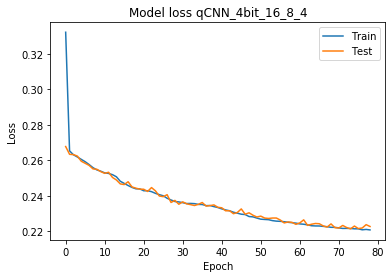

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss %s'%Layers)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("history_%s.png"%Layers)
plt.show()

In [16]:
x = val_input

decoded_Q = qautoencoder.predict(x)
encoded_Q = qencoder.predict(x)

input_Q   = np.reshape(x,(len(x),12,4))
decoded_Q = np.reshape(decoded_Q,(len(decoded_Q),12,4))
encoded_shape = encoded_Q.shape
encoded_Q = np.reshape(encoded_Q,(len(encoded_Q),encoded_shape[3],encoded_shape[1]))

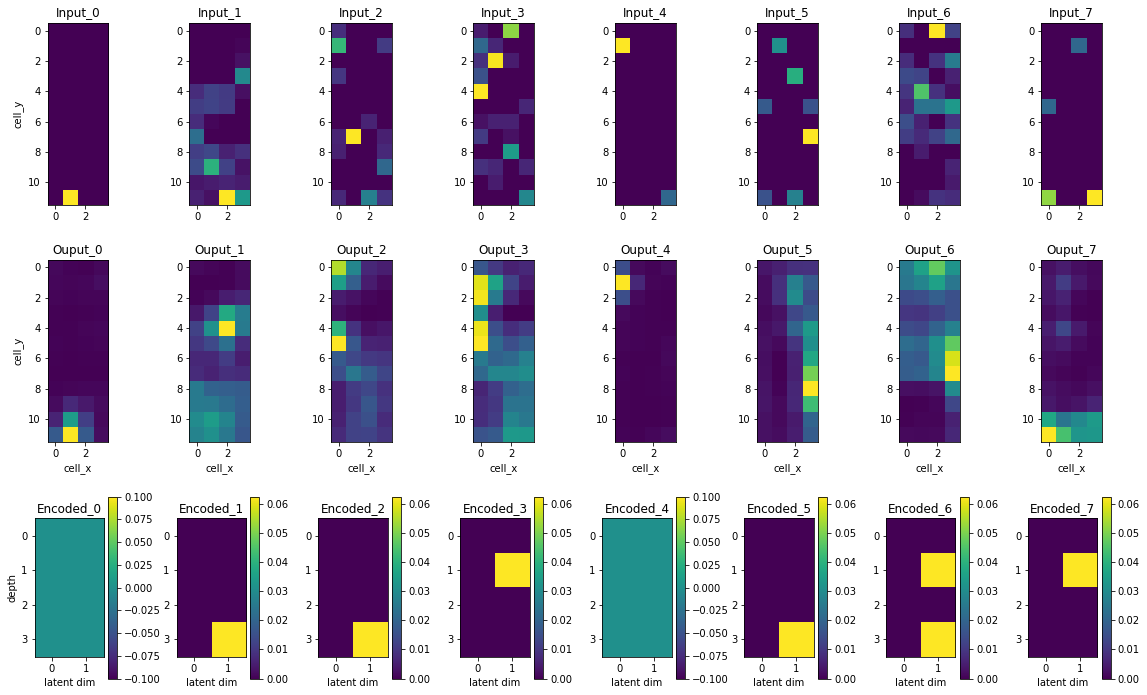

In [17]:

Nevents = 8
index = np.random.choice(x.shape[0], Nevents, replace=False)  

inputImg    = input_Q[index]
encodedImg  = encoded_Q[index]
outputImg   = decoded_Q[index]

fig, axs = plt.subplots(3, Nevents, figsize=(16, 10))

for i in range(0,Nevents):
    if i==0:
        axs[0,i].set(xlabel='',ylabel='cell_y',title='Input_%i'%i)
    else:
        axs[0,i].set(xlabel='',title='Input_%i'%i)        
    c1=axs[0,i].imshow(inputImg[i])
    
for i in range(0,Nevents):
    if i==0:
        axs[1,i].set(xlabel='cell_x',ylabel='cell_y',title='Ouput_%i'%i)        
    else:
        axs[1,i].set(xlabel='cell_x',title='Ouput_%i'%i)
    c1=axs[1,i].imshow(outputImg[i])

for i in range(0,Nevents):
    if i==0:
        axs[2,i].set(xlabel='latent dim',ylabel='depth',title='Encoded_%i'%i)
    else:
        axs[2,i].set(xlabel='latent dim',title='Encoded_%i'%i)
    c1=axs[2,i].imshow(encodedImg[i])
    plt.colorbar(c1,ax=axs[2,i])

plt.tight_layout()
plt.savefig("CNN_eg_%s.png"%Layers)

plt.show()

In [18]:
Layers

'qCNN_4bit_16_8_4'

In [19]:
from keras.models import model_from_json

json_string = encoder.to_json()
with open('./encoder_model_%s.json'%Layers,'w') as f:
    f.write(json_string)
encoder.save_weights('encoder_%s.hdf5'%Layers)

json_string = autoencoder.to_json()
with open('./autoencoder_model_%s.json'%Layers,'w') as f:
    f.write(json_string)
autoencoder.save_weights('autoencoder_%s.hdf5'%Layers)